In [1]:
import os
import sys
import json
import math
import torch
import numpy as np

import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':12,
})
from matplotlib import pyplot as plt

from torch import nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.networks.wgan import GoodNetwork
from DiffNet.DiffNetFEM import DiffNet2DFEM
# from DiffNet.datasets.single_instances.rectangles import RectangleManufactured
from DiffNet.datasets.single_instances.rectangles import SpaceTimeRectangleManufactured
from e3_st_mms_resmin import SpaceTimeHeat

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Global seed set to 42
Global seed set to 42


In [2]:
def plot_contours(k,f,u,u_exact):
    diff = u - u_exact
    # plotting        
    fig, axs = plt.subplots(1, 5, figsize=(3*5,2),
                        subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])              

    # print(np.linalg.norm(diff.flatten())/self.domain_size)
    im = axs[0].imshow(f,cmap='jet')
    # fig.colorbar(im, ax=axs[0], ticks=[0.0, 4.0, 8.0, 12.0, 16.0, 20.0]); axs[0].set_title(r'$f$')
    fig.colorbar(im, ax=axs[0]); axs[0].set_title(r'$f$')
    im = axs[1].imshow(k,cmap='jet')
    fig.colorbar(im, ax=axs[1]); axs[1].set_title(r'$\nu$')
    im = axs[2].imshow(u,cmap='jet', vmin=0.0, vmax=1.0)
    fig.colorbar(im, ax=axs[2]); axs[2].set_title(r'$u_{\theta}$')
    im = axs[3].imshow(u_exact,cmap='jet', vmin=0.0, vmax=1.0)
    fig.colorbar(im, ax=axs[3]); axs[3].set_title(r'$u_{exact}$')
    im = axs[4].imshow(diff,cmap='jet')
    fig.colorbar(im, ax=axs[4]); axs[4].set_title(r'$u_{\theta}-u_{exact}$')
    plt.show()
    # plt.savefig(os.path.join(self.logger[0].log_dir, 'contour_' + str(self.current_epoch) + '.png'))
    # self.logger[0].experiment.add_figure('Contour Plots', fig, self.current_epoch)
    # plt.close('all')

In [3]:
domain_size = 64
dir_string = "spacetime-heat"
max_epochs = 15

u_tensor = np.ones((1,1,domain_size,domain_size))
network = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor), requires_grad=True)])
dataset = SpaceTimeRectangleManufactured(domain_size=domain_size)
basecase = SpaceTimeHeat(network, dataset, batch_size=1, domain_size=domain_size, learning_rate=0.1)

logger = pl.loggers.TensorBoardLogger('.', name=dir_string)
# logger = pl.loggers.TensorBoardLogger('.', name="simple-resmin")
csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

early_stopping = pl.callbacks.early_stopping.EarlyStopping('loss',
    min_delta=1e-8, patience=10, verbose=False, mode='max', strict=True)
checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='loss',
    dirpath=logger.log_dir, filename='{epoch}-{step}',
    mode='min', save_last=True)

trainer = Trainer(gpus=[0],callbacks=[early_stopping],
    checkpoint_callback=checkpoint, logger=[logger,csv_logger],
    max_epochs=max_epochs, deterministic=True, profiler="simple")

trainer.fit(basecase)
torch.save(basecase.network, os.path.join(logger.log_dir, 'network.pt'))

basecase.calc_l2_err()

k =  tensor([[ 0.0854, -0.1093],
        [ 0.0665, -0.0427]])
k =  tensor([[-0.1093,  0.0854],
        [-0.0427,  0.0665]])
k =  tensor([[ 0.0348, -0.0586],
        [ 0.1172, -0.0934]])
k =  tensor([[-0.0586,  0.0348],
        [-0.0934,  0.1172]])
self.Kmatrices[0].shape =  torch.Size([1, 1, 2, 2])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory ./spacetime-heat/version_32 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type          | Params
--------------------------------------------
0 | network   | ParameterList | 4.1 K 
1 | N_gp      | ParameterList | 16    
2 | dN_x_gp   | ParameterList | 16    
3 | dN_y_gp   | ParameterList | 16    
4 | d2N_x_gp  | ParameterList | 16    
5 | d2N_y_gp  | ParameterList | 16    
6 | d2N_xy_gp | ParameterList | 16    
7 | Kmatrices | ParameterList | 16    
--------------------------------------------
4.1 K     Trainable params
112       Non-trainable params
4.2 K     Total params
0.017     Total estimated m

Epoch 0:   4%|▍         | 4/100 [00:00<00:03, 26.69it/s, loss=31.5, v_num=2_32]

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 14: 100%|██████████| 100/100 [00:01<00:00, 56.61it/s, loss=31.5, v_num=2_32]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  35.46          	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  2.1389         	|15             	|  32.083         	|  90.476         	|
run_training_batch                 	|  0.01592        	|1500           	|  23.879         	|  67.341         	|
optimizer_step_and_closure_0       	|  0.01567        	|1500           	|  23.505         	|  66.284         	|
training_step_and_backward         	|  0.003514       	|2589           	|  9.0976         	|  25.656         	|
backward                           


J =  6.298815822625346e-05
usol.shape = (64, 64)
uex.shape = (64, 64)
||u_sol||, ||uex|| =  0.5600990911227665 0.5621923864742658
||e||_{{L2}} =  0.003691226020042052
||e|| (vector-norm) =  0.0049361372366547585


J =  6.298815822625346e-05
usol.shape = (64, 64)
uex.shape = (64, 64)
||u_sol||, ||uex|| =  0.5600990911227665 0.5621923864742658
||e||_{{L2}} =  0.003691226020042052
||e|| (vector-norm) =  0.0049361372366547585


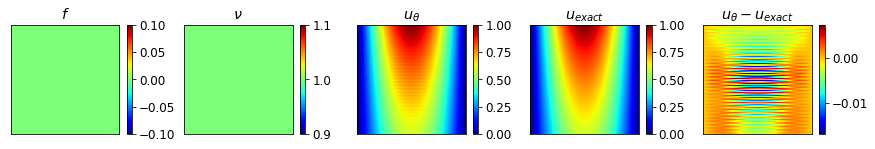

In [4]:
# Query
basecase.dataset[0]
inputs, forcing = basecase.dataset[0]
k, f, u = basecase.do_query(inputs, forcing) 
u_exact = basecase.u_exact.squeeze()
# L2 error calculation
basecase.calc_l2_err()
# plot
plot_contours(k,f,u,u_exact)

Text(0.5, 1.0, '$u_{\\theta}-u_{exact}$')

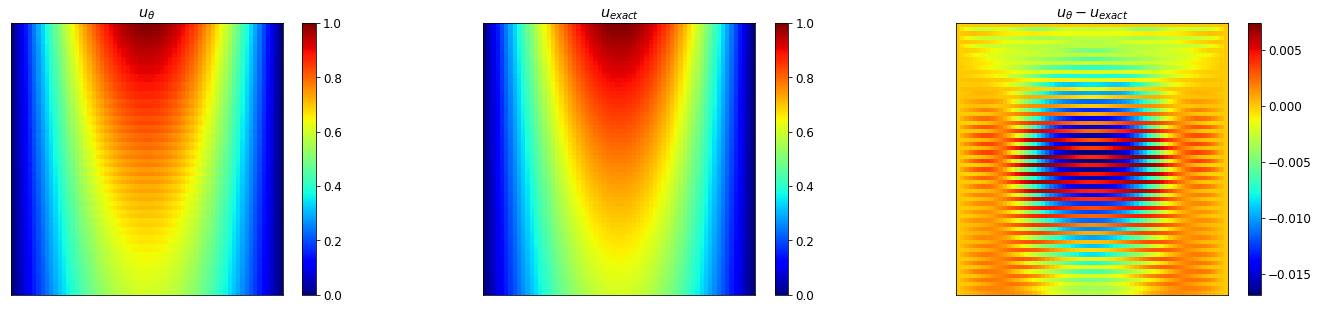

In [11]:
diff = u - u_exact
# plotting        
fig, axs = plt.subplots(1, 3, figsize=(8*3,5),
                    subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])              

im = axs[0].imshow(u,cmap='jet', vmin=0.0, vmax=1.0)
fig.colorbar(im, ax=axs[0]); axs[0].set_title(r'$u_{\theta}$')
im = axs[1].imshow(u_exact,cmap='jet', vmin=0.0, vmax=1.0)
fig.colorbar(im, ax=axs[1]); axs[1].set_title(r'$u_{exact}$')
im = axs[2].imshow(diff,cmap='jet')
fig.colorbar(im, ax=axs[2]); axs[2].set_title(r'$u_{\theta}-u_{exact}$')

(0.0, 0.005)

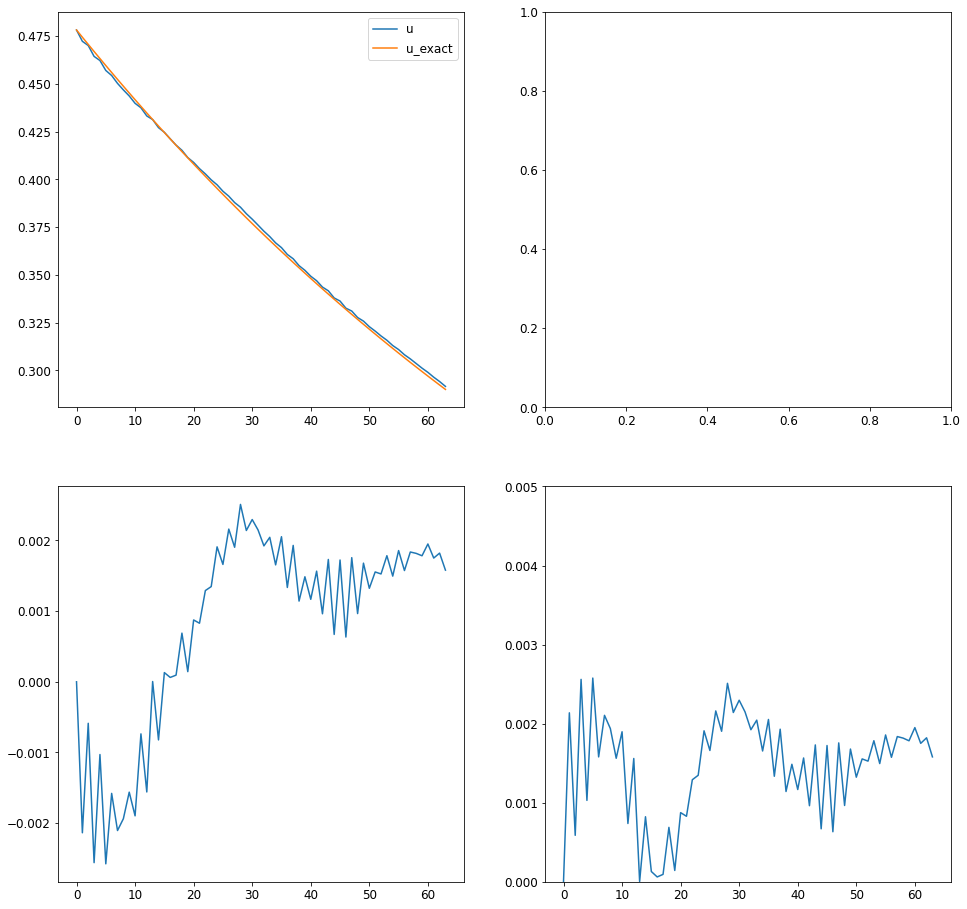

In [26]:
diff = u - u_exact
# plotting        
fig, axs = plt.subplots(2, 2, figsize=(16,16),
                    subplot_kw={'aspect': 'auto'}, sharex=False, sharey=False, squeeze=True)
# for ax in axs:
#     ax.set_xticks([])
#     ax.set_yticks([])              

im = axs[0,0].plot(u[:,10], label='u')
im = axs[0,0].plot(u_exact[:,10], label='u_exact')
axs[0,0].legend()
im = axs[1,0].plot(diff[:,10])
im = axs[1,1].plot(np.abs(diff[:,10])); axs[1,1].set_ylim([0,0.005])
# fig.colorbar(im, ax=axs[0]); axs[0].set_title(r'$u_{\theta}$')
# im = axs[1].imshow(u_exact,cmap='jet', vmin=0.0, vmax=1.0)
# fig.colorbar(im, ax=axs[1]); axs[1].set_title(r'$u_{exact}$')
# im = axs[2].imshow(diff,cmap='jet')
# fig.colorbar(im, ax=axs[2]); axs[2].set_title(r'$u_{\theta}-u_{exact}$')